# Create Components

In [1]:
from __future__ import division, print_function, absolute_import
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import cv2
import os
import sys
from PIL import Image
from timeit import time

# set config to initialize cudnn
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

from stereo_reconstruction import structure
from stereo_reconstruction import processor
from stereo_reconstruction.features import match_images

from yolo3_deepsort.yolo import YOLO
from yolo3_deepsort.deep_sort.detection import Detection
from yolo3_deepsort.deep_sort.tracker import Tracker
from yolo3_deepsort.tools import generate_detections as gdet
from yolo3_deepsort.tools.plot_utils import draw_one_box as draw_box
from yolo3_deepsort.deep_sort.detection import Detection as ddet
import yolo3_deepsort.tools.box_filter as box_filter

Using TensorFlow backend.


In [2]:
# create yolov3 detector
score_thre = 0.4
iou_thre = 0.3
yolo = YOLO(model_path = 'yolo3_deepsort/model_data/yolo_ori.h5',
            classes_path = 'yolo3_deepsort/model_data/coco_classes.txt',
            weights_only = True,
            score = score_thre,
            iou = iou_thre) # coco version
# yolo = YOLO(model_path = 'yolo3_deepsort/model_data/trained_weights_coco.h5',
#             classes_path = 'yolo3_deepsort/model_data/classes_name.txt',
#             weights_only = True,
#             score = score_thre,
#             iou = iou_thre) # our version

# create feature encoder
model_filename = 'yolo3_deepsort/model_data/mars-small128.pb'
encoder = gdet.create_box_encoder(model_filename,batch_size=1)

# create tracker
max_distance = 0.3
lambda0 = 1# SORT
nn_budget = None
tracker = Tracker(metric_mode="combine",max_cosine_distance=max_distance,
                      lambda0 = lambda0,nn_budget=nn_budget)

yolo3_deepsort/model_data/yolo_ori.h5 model, anchors, and classes loaded.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where






# 3D reconstruct

In [3]:
# Read Parameters
work_path = "/media/yxhuang/database/binocular_video/"
# work_path = r"G:/binocular_video/"
intrinsic_path = work_path + 'stereo_intrinsic.yml'
extrinsic_path = work_path + 'stereo_extrinsic.yml'
intrinsic_paras = cv2.FileStorage(intrinsic_path, cv2.FILE_STORAGE_READ)
extrinsic_paras = cv2.FileStorage(extrinsic_path, cv2.FILE_STORAGE_READ)
P1 = extrinsic_paras.getNode('P1').mat()
P2 = extrinsic_paras.getNode('P2').mat()
R1 = extrinsic_paras.getNode('R1').mat()
R2 = extrinsic_paras.getNode('R2').mat()
T1 = np.zeros((3,1))
T2 = extrinsic_paras.getNode('T').mat()
M1 = intrinsic_paras.getNode('M1').mat()
M2 = intrinsic_paras.getNode('M2').mat()
D1 = intrinsic_paras.getNode('D1').mat()
D2 = intrinsic_paras.getNode('D2').mat()


In [59]:
# Read Images

img_left = cv2.imread(work_path+'img/0_left.jpg')
img_right = cv2.imread(work_path+'img/0_right.jpg')

img_left_pil = Image.fromarray(img_left.copy()[...,::-1])
img_right_pil = Image.fromarray(img_right.copy()[...,::-1])

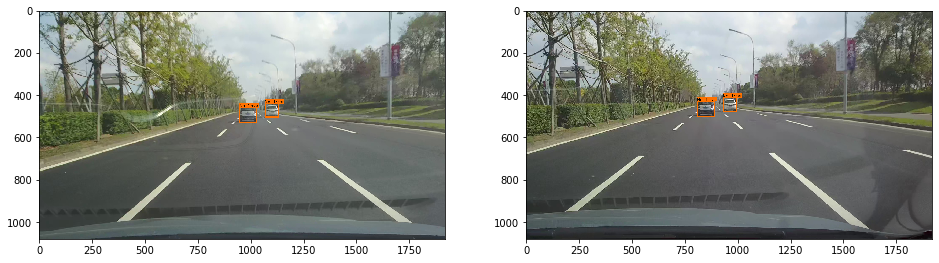

In [60]:
# Detection and Matching

COI = ['person','bicycle','car','motorcycle','bus','train','truck']#category of interest
h_img,w_img,_ = img_left.shape
thickness = 150
boxes,classes,scores = yolo.detect_image(img_left_pil)# detect object

# filter boxes
boxes, classes, scores = box_filter.remove_edge(boxes,classes,scores,thickness,(w_img,h_img))
boxes, classes, scores = box_filter.select_classes(boxes,classes,scores,COI)
boxes, classes, scores = box_filter.non_max_suppression(boxes,classes,scores,iou_thre)

boxes_matched = []
boxes = np.array(boxes)# easier to compute
img_left_draw = img_left_pil.copy()
img_right_draw = img_right_pil.copy()
for i,box in enumerate(boxes):
    ret,search_patch,box_matched = match_images(img_left,img_right,box,offset=(-400,-40,0,40),
                                   method = cv2.TM_CCOEFF_NORMED)# match two image
    boxes_matched.append(box_matched)
#     search_patches.append(search_patch)
#     rets.append(ret)
    
    object_id = '-1'
    object_class = classes[i]
    color = yolo.colors[yolo.class_names.index(object_class)]
    # draw boxes
    box[2:] = box[2:] + box[:2]# ltwh 2 ltrb. Note boxes had been changed!!!!!
    img_left_draw = draw_box(img_left_draw,box,object_id,object_class,color,20)
    img_right_draw = draw_box(img_right_draw,box_matched,object_id,object_class,color,20)
#     print("box_r",box_matched)
    
boxes_matched = np.array(boxes_matched)

# visualize
img_left_show = np.asarray(img_left_draw)
img_right_show = np.asarray(img_right_draw)
plt.figure(figsize=(16,10))
plt.subplot(121)
plt.imshow(img_left_show)
plt.subplot(122)
plt.imshow(img_right_show)

cv2.imshow('left',img_left_show[...,::-1])
cv2.imshow('right',img_right_show[...,::-1])
cv2.waitKey(0)
cv2.destroyAllWindows()

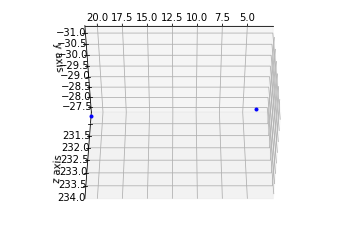

distance:
[23.27358215 23.73183776]
[[  3.60021553  20.05119647]
 [-27.52523527 -31.07130667]
 [231.07436569 234.41957209]
 [  1.           1.        ]]


In [64]:
# use the center of boxes stand for object's location
pts2D_1 = np.ones((3,len(boxes)),dtype='float')
pts2D_2 = np.ones((3,len(boxes)),dtype='float')

# boxes[:,2:] = boxes[:,2:] + boxes[:,:2]# ltwh 2 ltrb
for i in range(len(boxes)):
    pts2D_1[:2,i] = (boxes[i,:2] + boxes[i,2:])/2.
    pts2D_2[:2,i] = (boxes_matched[i,:2] + boxes_matched[i,2:])/2.

# triangulation
pts3D = structure.linear_triangulation(pts2D_1,pts2D_2,P1,P2)
# pts3D = structure.linear_triangulation(pts2D_1,pts2D_2,P2,P1)
# X朝右，Y朝上，Z朝前
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(pts3D[0], pts3D[1], pts3D[2], 'b.')
ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')
ax.view_init(elev=135, azim=90)
plt.show()

print("distance:")
print(np.sqrt(np.sum(pts3D[:3,:]**2,axis=0))/10)
print(pts3D)


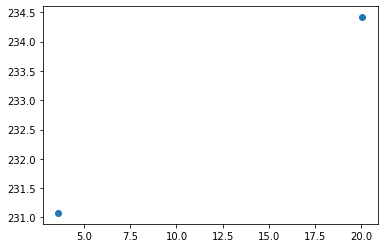

In [65]:
# 俯视图
plt.scatter(pts3D[0,:],pts3D[2,:])

# Tracking and Get 3D Coordination

## set vedio config

In [ ]:
# video_path = r"G:\binocular_video\20191022_022500_video.h265"
video_path = "/media/yxhuang/database/binocular_video/20191022_022500_video.h265"
cap = cv2.VideoCapture(video_path)
w = int(cap.get(3))
h = int(cap.get(4))
fps = cap.get(5)
thickness = 150
COI = ['person','bicycle','car','motorcycle','bus','train','truck']

write_flag = True
if write_flag:
    out = cv2.VideoWriter('result/roadtest_COCO.avi',cv2.VideoWriter_fourcc(*'XVID'), fps, (w//2,2*h))
fontsize = 25
current_frame_num = 0 #当前帧数

## set camera config 

In [ ]:
# Read Parameters

work_path = "/media/yxhuang/database/binocular_video/"
intrinsic_path = work_path + r'stereo_intrinsic.yml'
extrinsic_path = work_path + r'stereo_extrinsic.yml'
# intrinsic_path = r'G:\binocular_video\stereo_intrinsic.yml'
# extrinsic_path = r'G:\binocular_video\stereo_extrinsic.yml'
intrinsic_paras = cv2.FileStorage(intrinsic_path, cv2.FILE_STORAGE_READ)
extrinsic_paras = cv2.FileStorage(extrinsic_path, cv2.FILE_STORAGE_READ)
P1 = extrinsic_paras.getNode('P1').mat()
P2 = extrinsic_paras.getNode('P2').mat()
R1 = extrinsic_paras.getNode('R1').mat()
R2 = extrinsic_paras.getNode('R2').mat()
T1 = np.zeros((3,1))
T2 = extrinsic_paras.getNode('T').mat()
M1 = intrinsic_paras.getNode('M1').mat()
M2 = intrinsic_paras.getNode('M2').mat()
D1 = intrinsic_paras.getNode('D1').mat()
D2 = intrinsic_paras.getNode('D2').mat()

## tracking, detection, and get 3D coordination 

In [ ]:
while cap.isOpened():
    # read video
    ret,frame = cap.read()
    current_frame_num += 1
    if ret != True:
        break# it's really really really important!!!
        
    frame_left = frame[:,:w//2,:]
    frame_right = frame[:,w//2:,:]
    img_left_pil = Image.fromarray(frame_left.copy()[...,::-1])
    img_right_pil = Image.fromarray(frame_right.copy()[...,::-1])
    
    # detection
    boxes,classes,scores = yolo.detect_image(img_left_pil)
    
    # filter boxes
    boxes, classes, scores = box_filter.remove_edge(boxes,classes,scores,thickness,(w//2,h))
    boxes, classes, scores = box_filter.select_classes(boxes,classes,scores,COI)
    boxes, classes, scores = box_filter.non_max_suppression(boxes,classes,scores,iou_thre)
    
    pts3D = []
    boxes = np.array(boxes)# easier to compute
    for i,box in enumerate(boxes):
        ret,search_patch,box_matched = match_images(frame_left,frame_right,box,offset=(-400,-40,0,40),
                                       method = cv2.TM_CCOEFF_NORMED)# match two image
        box_matched = np.array(box_matched)
        pt2D_l = np.ones((3,1),dtype='float')#left center of box
        pt2D_r = np.ones((3,1),dtype='float')#righr center of box
        pt2D_l[:2,0] = boxes[i,:2] + boxes[i,2:]/2.
        pt2D_r[:2,0] = (box_matched[:2] + box_matched[2:])/2.

        # triangulation
        pt3D = structure.linear_triangulation(pt2D_l,pt2D_r,P1,P2)
        pts3D.append(pt3D[:3])
#     print(np.reshape(np.array(pts3D),(3,len(pts3D))))

    # encoder features
    features = encoder(frame_left,boxes)
    detections = [Detection(bbox,score,class_,feature,XYZ,current_frame_num)
                    for bbox,score,class_,feature,XYZ in 
                      zip(boxes,scores,classes,features,pts3D)]
    
    # call the tracker
    tracker.predict()
    tracker.update(detections)
    
    # Visualize result++++++++++++++++++
    img_left_draw = img_left_pil.copy()
    img_right_draw = img_right_pil.copy()
    for i,track in enumerate(tracker.tracks):
        if not track.is_confirmed() or track.time_since_update > 1:
            continue
        
        # track.to_tlbr() actually get ltrb && track.to_tlwh() actually get ltwh 
        bbox = track.to_tlbr()
        _,_,bbox_matched = match_images(frame_left,frame_right,track.to_tlwh().astype(int),
                                        offset=(-400,-40,0,40),method = cv2.TM_CCOEFF_NORMED)# match two image
        
        # property of the object
        object_id = track.track_id
        object_class = track.object_class
        color = yolo.colors[yolo.class_names.index(object_class)]
        # draw boxes
        img_left_draw = draw_box(img_left_draw,bbox,object_id,object_class,color,fontsize)
        img_right_draw = draw_box(img_right_draw,bbox_matched,object_id,object_class,color,fontsize)
    
    img_left_show = np.asarray(img_left_draw)
    img_right_show = np.asarray(img_right_draw)
    img_show = np.concatenate((img_left_show,img_right_show),axis = 0)
    
    if write_flag:
        out.write(img_show[...,::-1])# save result
    cv2.imshow('demo',cv2.resize(img_show[...,::-1],(int(w/2.5),int(h/1.5))))
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
if write_flag:
    out.release()
cap.release()
cv2.destroyAllWindows()

## Save tracker information

In [ ]:
import pickle
import json
tracks = tracker.tracks + tracker.deleted_tracks
pickle.dump(tracks,open('result/tracks_pickle_COCO.txt', 'wb') )

# sort tracks by track id
track_ids = [t.track_id for t in tracks]
idx = np.array(np.argsort(track_ids),dtype='int32')
tracks = [tracks[i] for i in idx]

# output tracks into json file
output_path = "result/tracking_result_COCO.json"
tracks_dict_list = []
for track in tracks:
    track_dict = {}
    track_dict["track_id"] = track.track_id
    track_dict["category"] = track.object_class
    track.XYZ_array = np.array(track.XYZ_array)
    track_dict["XYZs"] = track.XYZ_array.tolist()
    track_dict["frames"] = track.frame_array
    tracks_dict_list.append(track_dict)
with open(output_path,"w") as f:
    json.dump(tracks_dict_list, f)
#     f.write(json.dumps(tracks_dict_list))

# Visualize tracklet

In [ ]:
import json
# load data
with open("result/tracking_result.json","r") as f:
    tracks_json = json.load(f)
    
track_id = 429 #要查看的track的ID
fig = plt.figure()
ax = fig.gca(projection='3d')
track = tracks_json[track_id]
# X朝右, Z朝前
ax.scatter(track["XYZs"][0], track["XYZs"][1], track["XYZs"][2], 'b.')
ax.set_xlabel('x axis')
ax.set_ylabel('y axis')
ax.set_zlabel('z axis')
ax.view_init(elev=135, azim=90)
plt.show()

In [ ]:
#俯视图
plt.scatter(track["XYZs"][0],track["XYZs"][2])
plt.xlabel("X")
plt.ylabel("Z")

# Detect Only

In [ ]:
# video_path = r"G:\binocular_video\20191022_022500_video.h265"
video_path = "/media/yxhuang/database/binocular_video/20191022_022500_video.h265"
cap = cv2.VideoCapture(video_path)
w = int(cap.get(3))
h = int(cap.get(4))
fps = cap.get(5)
thickness = 150
COI = ['person','bicycle','car','motorcycle','bus','train','truck']

write_flag = True
if write_flag:
    out = cv2.VideoWriter('result/roadtest_DetectOnly.avi',cv2.VideoWriter_fourcc(*'XVID'), fps, (w//2,2*h))
fontsize = 25
current_frame_num = 0 #当前帧数

In [ ]:
while cap.isOpened():
    # read video
    ret,frame = cap.read()
    current_frame_num += 1
    if ret != True:
        break# it's really really really important!!!
        
    frame_left = frame[:,:w//2,:]
    frame_right = frame[:,w//2:,:]
    img_left_pil = Image.fromarray(frame_left.copy()[...,::-1])
    img_right_pil = Image.fromarray(frame_right.copy()[...,::-1])
    
    # detection
    boxes,classes,scores = yolo.detect_image(img_left_pil)
    boxes_matched = []
    
    # filter boxes
    boxes, classes, scores = box_filter.remove_edge(boxes,classes,scores,thickness,(w//2,h))
    boxes, classes, scores = box_filter.select_classes(boxes,classes,scores,COI)
    boxes, classes, scores = box_filter.non_max_suppression(boxes,classes,scores,iou_thre)
    
    pts3D = []
    boxes = np.array(boxes)# easier to compute
    for i,box in enumerate(boxes):
        ret,search_patch,box_matched = match_images(frame_left,frame_right,box,offset=(-400,-40,0,40),
                                       method = cv2.TM_CCOEFF_NORMED)# match two image
        boxes_matched.append(box_matched)
        box_matched = np.array(box_matched)
        pt2D_l = np.ones((3,1),dtype='float')#left center of box
        pt2D_r = np.ones((3,1),dtype='float')#righr center of box
        pt2D_l[:2,0] = boxes[i,:2] + boxes[i,2:]
        pt2D_r[:2,0] = (box_matched[:2] + box_matched[2:])/2.

        # triangulation
        pt3D = structure.linear_triangulation(pt2D_l,pt2D_r,P1,P2)
        pts3D.append(pt3D[:3])
    
    # Visualize result++++++++++++++++++
    img_left_draw = img_left_pil.copy()
    img_right_draw = img_right_pil.copy()
    for i,box in enumerate(boxes):
        box = np.array(box)
        box[2:] = box[:2] + box[2:]
        # property of the object
        object_id = 0
        object_class = classes[i]
        color = yolo.colors[yolo.class_names.index(object_class)]
        # draw boxes
        img_left_draw = draw_box(img_left_draw,box,object_id,object_class,color,fontsize)
        img_right_draw = draw_box(img_right_draw,boxes_matched[i],object_id,object_class,color,fontsize)
    
    img_left_show = np.asarray(img_left_draw)
    img_right_show = np.asarray(img_right_draw)
    img_show = np.concatenate((img_left_show,img_right_show),axis = 0)
    
    if write_flag:
        out.write(img_show[...,::-1])# save result
    cv2.imshow('demo',cv2.resize(img_show[...,::-1],(int(w/2.5),int(h/1.5))))
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
if write_flag:
    out.release()
cap.release()
cv2.destroyAllWindows()